## BAGIAN 1: IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import gc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, 
    precision_score, recall_score, confusion_matrix
)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import backend as K

# Flower imports
import flwr as fl
from flwr.simulation import start_simulation
from flwr.server.strategy import FedProx

# Local imports - import directly from current directory
from task import get_model_by_type, ProximalModel
from utils import (
    split_data_non_iid_label,
    evaluate_model_metrics,
    prepare_client_configs,
    print_summary_table
)

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ============================================================================
# KONFIGURASI EKSPERIMEN - UBAH DI SINI
# ============================================================================
NUM_ROUNDS = 10             # Jumlah putaran komunikasi federated learning
NUM_CLIENTS = 3             # Jumlah klien dalam sistem
LOCAL_EPOCHS = 3            # Jumlah epoch pelatihan lokal per klien per round
BATCH_SIZE_BINARY = 512     # Ukuran batch untuk model binary (optimized)
BATCH_SIZE_MULTI = 256      # Ukuran batch untuk model multi-class (optimized)
LEARNING_RATE = 0.001       # Learning rate untuk optimizer
MU_BINARY = 0.01            # FedProx proximal term coefficient untuk binary
MU_MULTI = 0.001            # FedProx proximal term coefficient untuk multi-class (reduced 10x)
SMOTE_TARGET_MITM = 3000    # Target jumlah sampel MITM setelah SMOTE
ALPHA_BINARY = 0.4          # Parameter alpha Dirichlet untuk data binary (Non-IID)
ALPHA_MULTI = 0.6           # Parameter alpha Dirichlet untuk data multi-class (Non-IID)
FRAMEWORK = "Flower (flwr)" # Framework yang digunakan
ALGORITHM = "Federated Proximal (FedProx)"  # Algoritma federated learning
DATA_DISTRIBUTION = "Non-IID (Dirichlet)"   # Jenis distribusi data
# ============================================================================

print("=== FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER ===")
print(f"Konfigurasi: {NUM_CLIENTS} Klien, {NUM_ROUNDS} Putaran, {LOCAL_EPOCHS} Local Epochs")
print(f"Proximal Term (μ) - Binary: {MU_BINARY}, Multi-class: {MU_MULTI}")
print(f"Proximal Term Coefficient (μ): {MU_MULTI}")
print(f"SMOTE Target for MITM: {SMOTE_TARGET_MITM:,} samples")
print("Semua library berhasil diimpor.")
print(f"TensorFlow version: {tf.__version__}")
print(f"Flower version: {fl.__version__}")

=== FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER ===
Konfigurasi: 3 Klien, 10 Putaran, 3 Local Epochs
Proximal Term (μ) - Binary: 0.01, Multi-class: 0.001
Proximal Term Coefficient (μ): 0.001
SMOTE Target for MITM: 3,000 samples
Semua library berhasil diimpor.
TensorFlow version: 2.20.0
Flower version: 1.24.0


## BAGIAN 2: PEMUATAN DATA

In [3]:
print("--- Memuat Dataset ---")
try:
    df = pd.read_csv(
        "/home/elnoersan/Skripsi/Paper/NotebookTODO/EDA/Cleaned Dataset/cleaned_train_test_network.csv"
    )
    print(f"Dataset berhasil dimuat. Shape: {df.shape}")
except FileNotFoundError:
    print("File dataset tidak ditemukan. Pastikan path benar.")
    raise

--- Memuat Dataset ---
Dataset berhasil dimuat. Shape: (211043, 44)


## BAGIAN 3: PREPARASI DATA

In [4]:
print("--- PREPARASI DATA UNTUK DETEKSI BINER ---")
df_binary = df.drop(columns=['src_ip','src_port','dst_ip','dst_port','type', 'weird_name','weird_addl','weird_notice'], errors='ignore')
X_binary = df_binary.drop('label', axis=1)
y_binary = df_binary['label']

for col in X_binary.select_dtypes(include=['object']).columns:
    X_binary[col] = LabelEncoder().fit_transform(X_binary[col])

# ✅ BENAR - Split → RFE → Scale (mencegah data leakage)
print("Step 1: Split data train/test untuk binary...")
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print("Step 2: Feature selection HANYA pada data training...")
n_features_bin = min(30, X_train_bin.shape[1])
rfe = RFE(
    estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), 
    n_features_to_select=n_features_bin
)
X_train_bin_selected = rfe.fit_transform(X_train_bin, y_train_bin)
X_test_bin_selected = rfe.transform(X_test_bin)  # Apply same feature selection to test

print("Step 3: Scale data - fit pada train, transform pada test...")
scaler_binary = StandardScaler()
X_train_bin_scaled = scaler_binary.fit_transform(X_train_bin_selected)
X_test_bin_scaled = scaler_binary.transform(X_test_bin_selected)

print(f"Data biner siap:")
print(f"  - Train: {X_train_bin_scaled.shape}")
print(f"  - Test: {X_test_bin_scaled.shape}")

gc.collect()

print("\n--- PREPARASI DATA UNTUK KLASIFIKASI MULTI-KELAS ---")
df_multi = df.drop(columns=['src_ip','src_port','dst_ip','dst_port', 'label', 'weird_name','weird_addl','weird_notice'], errors='ignore')
y_multi = df_multi['type']
X_multi = df_multi.drop('type', axis=1)

le_target = LabelEncoder()
y_multi_encoded = le_target.fit_transform(y_multi)
num_classes = len(le_target.classes_)
print(f"Jumlah kelas: {num_classes}, Nama kelas: {list(le_target.classes_)}")

for col in X_multi.select_dtypes(include=['object']).columns:
    X_multi[col] = LabelEncoder().fit_transform(X_multi[col])

# ✅ BENAR - Split → SMOTE → RFE → Scale (mencegah data leakage)
print("Step 1: Split data train/test untuk multi-class...")
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi_encoded, test_size=0.2, random_state=42, stratify=y_multi_encoded
)

# Display class distribution BEFORE SMOTE
print("\n📊 Distribusi kelas SEBELUM SMOTE (Training Data):")
unique, counts = np.unique(y_train_multi, return_counts=True)
class_dist_before = dict(zip(unique, counts))
for class_idx, count in sorted(class_dist_before.items()):
    class_name = le_target.classes_[class_idx]
    print(f"   • {class_name}: {count:,} sampel")
print(f"   TOTAL: {len(y_train_multi):,} sampel")

# Step 2: Apply SMOTE to oversample MITM attacks (and potentially other minorities)
print("\nStep 2: Applying SMOTE untuk oversampling kelas minoritas...")
print(f"   Target: MITM attack dari ~833 → {SMOTE_TARGET_MITM:,} sampel")

# Define sampling strategy: oversample MITM to target, keep others as is
mitm_idx = list(le_target.classes_).index('mitm')
sampling_strategy = {mitm_idx: SMOTE_TARGET_MITM}

# Check if we have enough neighbors for SMOTE
mitm_count = class_dist_before.get(mitm_idx, 0)
k_neighbors = min(5, mitm_count - 1) if mitm_count > 1 else 1

smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi, y_train_multi)

# Display class distribution AFTER SMOTE
print("\n📊 Distribusi kelas SETELAH SMOTE (Training Data):")
unique, counts = np.unique(y_train_multi_resampled, return_counts=True)
class_dist_after = dict(zip(unique, counts))
for class_idx, count in sorted(class_dist_after.items()):
    class_name = le_target.classes_[class_idx]
    before_count = class_dist_before.get(class_idx, 0)
    change = count - before_count
    if change > 0:
        print(f"   • {class_name}: {count:,} sampel (+{change:,} synthetic) ⬆️")
    else:
        print(f"   • {class_name}: {count:,} sampel")
print(f"   TOTAL: {len(y_train_multi_resampled):,} sampel (+{len(y_train_multi_resampled) - len(y_train_multi):,} synthetic)")

print("\nStep 3: Feature selection HANYA pada data training (post-SMOTE)...")
n_features_multi = min(35, X_train_multi_resampled.shape[1])
rfe_multi = RFE(
    estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), 
    n_features_to_select=n_features_multi
)
X_train_multi_selected = rfe_multi.fit_transform(X_train_multi_resampled, y_train_multi_resampled)
X_test_multi_selected = rfe_multi.transform(X_test_multi)  # Apply same feature selection to test

print("Step 4: Scale data - fit pada train (post-SMOTE), transform pada test...")
scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi_selected)
X_test_multi_scaled = scaler_multi.transform(X_test_multi_selected)

print(f"\nData multi-kelas siap:")
print(f"  - Train: {X_train_multi_scaled.shape} (dengan SMOTE)")
print(f"  - Test: {X_test_multi_scaled.shape} (tanpa SMOTE)")

gc.collect()


--- PREPARASI DATA UNTUK DETEKSI BINER ---
Step 1: Split data train/test untuk binary...
Step 2: Feature selection HANYA pada data training...
Step 3: Scale data - fit pada train, transform pada test...
Data biner siap:
  - Train: (168834, 30)
  - Test: (42209, 30)

--- PREPARASI DATA UNTUK KLASIFIKASI MULTI-KELAS ---
Jumlah kelas: 10, Nama kelas: ['backdoor', 'ddos', 'dos', 'injection', 'mitm', 'normal', 'password', 'ransomware', 'scanning', 'xss']
Step 1: Split data train/test untuk multi-class...

📊 Distribusi kelas SEBELUM SMOTE (Training Data):
   • backdoor: 16,000 sampel
   • ddos: 16,000 sampel
   • dos: 16,000 sampel
   • injection: 16,000 sampel
   • mitm: 834 sampel
   • normal: 40,000 sampel
   • password: 16,000 sampel
   • ransomware: 16,000 sampel
   • scanning: 16,000 sampel
   • xss: 16,000 sampel
   TOTAL: 168,834 sampel

Step 2: Applying SMOTE untuk oversampling kelas minoritas...
   Target: MITM attack dari ~833 → 3,000 sampel

📊 Distribusi kelas SETELAH SMOTE (Trai

24

## BAGIAN 4: SPLIT DATA KE KLIEN (NON-IID)

In [5]:
# Split data untuk klien menggunakan konfigurasi alpha yang sudah didefinisikan
# Gunakan data TRAINING yang sudah di-scale (bukan semua data)
# PENTING: Untuk multi-class, gunakan data yang sudah di-SMOTE
client_data_binary = split_data_non_iid_label(X_train_bin_scaled, y_train_bin, n_clients=NUM_CLIENTS, alpha=ALPHA_BINARY)
client_data_multi = split_data_non_iid_label(X_train_multi_scaled, y_train_multi_resampled, n_clients=NUM_CLIENTS, alpha=ALPHA_MULTI)

print(f"\n✅ Data test sudah siap dari cell sebelumnya:")
print(f"   - Binary Test: {X_test_bin_scaled.shape}")
print(f"   - Multi-class Test: {X_test_multi_scaled.shape}")
print(f"\n✅ Data training dengan SMOTE telah didistribusikan ke {NUM_CLIENTS} klien (Non-IID)")



[INFO] Splitting data for 3 clients with Non-IID (alpha=0.4)...


    Client 1: 40199 samples, distribution: {np.int64(0): np.int64(33298), np.int64(1): np.int64(6901)}
    Client 2: 127540 samples, distribution: {np.int64(0): np.int64(6115), np.int64(1): np.int64(121425)}
    Client 3: 1095 samples, distribution: {np.int64(0): np.int64(587), np.int64(1): np.int64(508)}

[INFO] Splitting data for 3 clients with Non-IID (alpha=0.6)...
    Client 1: 47018 samples, distribution: {np.int64(0): np.int64(3836), np.int64(1): np.int64(7949), np.int64(2): np.int64(3701), np.int64(3): np.int64(5904), np.int64(4): np.int64(481), np.int64(5): np.int64(664), np.int64(6): np.int64(9372), np.int64(7): np.int64(3964), np.int64(8): np.int64(249), np.int64(9): np.int64(10898)}
    Client 2: 59329 samples, distribution: {np.int64(0): np.int64(5010), np.int64(1): np.int64(12), np.int64(2): np.int64(9911), np.int64(3): np.int64(7762), np.int64(4): np.int64(962), np.int64(5): np.int64(14972), np.int64(6): np.int64(1445), np.int64(7): np.int64(2850), np.int64(8): np.int64(

## BAGIAN 5: DEFINISI FUNGSI UNTUK FLOWER CLIENT DENGAN FEDPROX

In [6]:
class FlowerClientProx(fl.client.NumPyClient):
    """Flower client untuk federated learning dengan FedProx."""
    
    def __init__(self, client_id, X_train, y_train, X_test, y_test, 
                 model_type, input_shape, num_classes, config):
        self.client_id = client_id
        self.X_train = X_train.astype(np.float32)
        self.y_train = y_train
        self.X_test = X_test.astype(np.float32) if X_test is not None else None
        self.y_test = y_test
        self.model_type = model_type
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.config = config
        
        # Untuk CNN, reshape input
        if 'cnn' in model_type:
            self.X_train = self.X_train.reshape(-1, input_shape, 1)
            if self.X_test is not None:
                self.X_test = self.X_test.reshape(-1, input_shape, 1)
    
    def get_parameters(self, config):
        """Return model parameters."""
        K.clear_session()
        temp_model = get_model_by_type(
            self.model_type, self.input_shape, 
            self.num_classes, self.config['learning_rate']
        )
        weights = temp_model.get_weights()
        del temp_model
        K.clear_session()
        return weights
    
    def set_parameters(self, parameters):
        """Set model parameters - not used in this implementation."""
        pass
    
    def fit(self, parameters, config):
        """Train model on local data using FedProx.
        
        The server sends 'proximal_mu' in the config dictionary.
        """
        # Clear previous session state
        K.clear_session()
        
        # Get proximal_mu from server config (sent by FedProx strategy)
        proximal_mu = config.get('proximal_mu', 0.01)
        
        # Create base model and set global weights
        base_model = get_model_by_type(
            self.model_type, self.input_shape, 
            self.num_classes, self.config['learning_rate']
        )
        base_model.set_weights(parameters)
        
        # Wrap with ProximalModel (parameters are the global weights for proximal term)
        proximal_model = ProximalModel(
            base_model, 
            parameters, 
            proximal_mu  # Use mu from server config
        )
        
        # Compile proximal model
        loss_fn = 'binary_crossentropy' if self.num_classes == 1 else 'sparse_categorical_crossentropy'
        proximal_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.config['learning_rate']),
            loss=loss_fn,
            metrics=['accuracy']
        )
        
        # Train with proximal term
        history = proximal_model.fit(
            self.X_train, self.y_train,
            epochs=self.config['local_epochs'],
            batch_size=self.config['batch_size'],
            verbose=0
        )
        
        # Extract updated weights from the base model (not wrapper)
        updated_weights = proximal_model.model.get_weights()
        
        # Prepare metrics
        metrics = {
            "train_loss": history.history['loss'][-1],
            "train_acc": history.history['accuracy'][-1]
        }
        
        # Clean up
        del base_model
        del proximal_model
        K.clear_session()
        
        return updated_weights, len(self.X_train), metrics
    
    def evaluate(self, parameters, config):
        """Evaluate model on local test data."""
        if self.X_test is None:
            return 0.0, 0, {}
        
        # Clear session and create fresh model for evaluation
        K.clear_session()
        
        eval_model = get_model_by_type(
            self.model_type, self.input_shape, 
            self.num_classes, self.config['learning_rate']
        )
        eval_model.set_weights(parameters)
        
        loss, accuracy = eval_model.evaluate(
            self.X_test, self.y_test, 
            batch_size=self.config['batch_size'], 
            verbose=0
        )
        
        # Clean up
        del eval_model
        K.clear_session()
        
        return loss, len(self.X_test), {"eval_acc": accuracy}


def create_client_fn_prox(client_data, test_data, model_type, input_shape, num_classes, config):
    """Factory function to create Flower clients with FedProx."""
    X_test, y_test = test_data
    
    def client_fn(cid: str) -> FlowerClientProx:
        client_id = int(cid)
        X_train, y_train = client_data[client_id]
        
        return FlowerClientProx(
            client_id, X_train, y_train, X_test, y_test,
            model_type, input_shape, num_classes, config
        )
    
    return client_fn

print("✅ Flower FedProx client class dan factory function didefinisikan")

✅ Flower FedProx client class dan factory function didefinisikan


## BAGIAN 6: FUNGSI PELATIHAN FEDERATED DENGAN FEDPROX

In [7]:
def run_federated_learning_fedprox(
    client_data,
    test_data,
    model_type,
    input_shape,
    num_classes,
    num_rounds=5,
    num_clients=3,
    local_epochs=1,
    batch_size=256,
    learning_rate=0.001,
    mu=0.01,
    fraction_fit=1.0,
    fraction_evaluate=1.0
):
    """Run federated learning using Flower simulation with FedProx.
    
    Args:
        client_data: List of (X, y) tuples for each client
        test_data: Tuple of (X_test, y_test) for evaluation
        model_type: Type of model to use
        input_shape: Number of input features
        num_classes: Number of output classes
        num_rounds: Number of federated rounds
        num_clients: Number of clients
        local_epochs: Epochs per client per round
        batch_size: Batch size for training
        learning_rate: Learning rate
        mu: FedProx proximal term coefficient
        fraction_fit: Fraction of clients for training
        fraction_evaluate: Fraction of clients for evaluation
        
    Returns:
        Tuple of (final_model, history)
    """
    print(f"\n[INFO] Starting Flower FedProx federated learning for {model_type}...")
    print(f"   Clients: {num_clients} | Rounds: {num_rounds} | Local epochs: {local_epochs}")
    print(f"   Proximal term (μ): {mu}")
    
    # Configuration
    config = {
        'local_epochs': local_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
    }
    
    # Create client factory
    client_fn = create_client_fn_prox(
        client_data, test_data, model_type, 
        input_shape, num_classes, config
    )
    
    # Create initial model to get parameters
    initial_model = get_model_by_type(model_type, input_shape, num_classes, learning_rate)
    initial_parameters = fl.common.ndarrays_to_parameters(initial_model.get_weights())
    
    # Define strategy with custom aggregation
    final_weights = [None]
    history_dict = {
        'train_accuracy': [],
        'train_loss': [],
        'eval_accuracy': [],
        'eval_loss': [],
        'round_time': [],
        'total_time': 0
    }
    
    round_start_time = [time.time()]
    
    # Use FedProx strategy from Flower
    from flwr.server.strategy import FedProx
    
    class FedProxWithMetrics(FedProx):
        def aggregate_fit(self, server_round, results, failures):
            round_time = time.time() - round_start_time[0]
            history_dict['round_time'].append(round_time)
            
            aggregated_result = super().aggregate_fit(server_round, results, failures)
            if aggregated_result is not None:
                final_weights[0] = aggregated_result[0]
                
                if results:
                    train_losses = [fit_res.metrics.get('train_loss', 0) for _, fit_res in results if 'train_loss' in fit_res.metrics]
                    train_accs = [fit_res.metrics.get('train_acc', 0) for _, fit_res in results if 'train_acc' in fit_res.metrics]
                    
                    if train_losses:
                        avg_loss = np.mean(train_losses)
                        history_dict['train_loss'].append(avg_loss)
                        print(f"      Round {server_round} - Avg Train Loss: {avg_loss:.4f}")
                    
                    if train_accs:
                        avg_acc = np.mean(train_accs)
                        history_dict['train_accuracy'].append(avg_acc)
                        print(f"      Round {server_round} - Avg Train Acc: {avg_acc:.4f} - Time: {round_time:.2f}s")
            
            round_start_time[0] = time.time()
            return aggregated_result
        
        def aggregate_evaluate(self, server_round, results, failures):
            aggregated_result = super().aggregate_evaluate(server_round, results, failures)
            
            if results:
                eval_losses = [eval_res.loss for _, eval_res in results]
                eval_accs = [eval_res.metrics.get('eval_acc', 0) for _, eval_res in results if 'eval_acc' in eval_res.metrics]
                
                if eval_losses:
                    avg_eval_loss = np.mean(eval_losses)
                    history_dict['eval_loss'].append(avg_eval_loss)
                
                if eval_accs:
                    avg_eval_acc = np.mean(eval_accs)
                    history_dict['eval_accuracy'].append(avg_eval_acc)
            
            return aggregated_result
    
    strategy = FedProxWithMetrics(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=max(2, int(num_clients * fraction_fit)),
        min_evaluate_clients=max(2, int(num_clients * fraction_evaluate)),
        min_available_clients=num_clients,
        initial_parameters=initial_parameters,
        proximal_mu=mu,  # FedProx-specific parameter
    )
    
    # Start simulation
    start_time = time.time()
    
    history = start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        config=fl.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
    )
    
    total_time = time.time() - start_time
    history_dict['total_time'] = total_time
    
    # Get final model
    final_model = get_model_by_type(model_type, input_shape, num_classes, learning_rate)
    
    if final_weights[0] is not None:
        parameters = fl.common.parameters_to_ndarrays(final_weights[0])
        final_model.set_weights(parameters)
        print(f"   ✓ Model weights updated from FedProx training")
    else:
        print(f"   ⚠ Warning: Using initial model weights")
    
    print(f"\n✅ FedProx federated learning completed in {total_time:.2f}s")
    print(f"   📊 Captured {len(history_dict['train_accuracy'])} rounds of training metrics")
    print(f"   ⏱️  Avg time per round: {np.mean(history_dict['round_time']):.2f}s")
    
    return final_model, history_dict

print("✅ Fungsi federated learning FedProx didefinisikan")

✅ Fungsi federated learning FedProx didefinisikan


## BAGIAN 7: PELATIHAN SEMUA MODEL DENGAN FEDPROX

In [8]:
print("\n" + "="*70)
print("MEMULAI PELATIHAN FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER")
print(f"Proximal Term (μ) - Binary: {MU_BINARY}, Multi-class: {MU_MULTI}")
print("="*70)

all_models = {}
all_histories = {}
all_metrics = {}

# Training Binary Models
print("\n--- PELATIHAN DETEKSI BINER DENGAN FEDPROX ---")

print("\n⚙️ Melatih Model MLP Binary...")
all_models['mlp_binary'], all_histories['mlp_binary'] = run_federated_learning_fedprox(
    client_data_binary,
    (X_test_bin_scaled, y_test_bin),
    'mlp_binary',
    X_train_bin_scaled.shape[1],
    1,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_BINARY,
    learning_rate=LEARNING_RATE,
    mu=MU_BINARY
)

print("\n⚙️ Melatih Model CNN Binary...")
all_models['cnn_binary'], all_histories['cnn_binary'] = run_federated_learning_fedprox(
    client_data_binary,
    (X_test_bin_scaled, y_test_bin),
    'cnn_binary',
    X_train_bin_scaled.shape[1],
    1,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_BINARY,
    learning_rate=LEARNING_RATE,
    mu=MU_BINARY
)

# Training Multi-class Models
print("\n--- PELATIHAN KLASIFIKASI MULTI-KELAS DENGAN FEDPROX ---")

print("\n⚙️ Melatih Model MLP Multi-class...")
all_models['mlp_multi'], all_histories['mlp_multi'] = run_federated_learning_fedprox(
    client_data_multi,
    (X_test_multi_scaled, y_test_multi),
    'mlp_multi',
    X_train_multi_scaled.shape[1],
    num_classes,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_MULTI,
    learning_rate=LEARNING_RATE,
    mu=MU_MULTI
)

print("\n⚙️ Melatih Model CNN Multi-class...")
all_models['cnn_multi'], all_histories['cnn_multi'] = run_federated_learning_fedprox(
    client_data_multi,
    (X_test_multi_scaled, y_test_multi),
    'cnn_multi',
    X_train_multi_scaled.shape[1],
    num_classes,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_MULTI,
    learning_rate=LEARNING_RATE,
    mu=MU_MULTI
)

print("\n✅ Semua model berhasil dilatih dengan FedProx!")


MEMULAI PELATIHAN FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER
Proximal Term (μ) - Binary: 0.01, Multi-class: 0.001

--- PELATIHAN DETEKSI BINER DENGAN FEDPROX ---

⚙️ Melatih Model MLP Binary...

[INFO] Starting Flower FedProx federated learning for mlp_binary...
   Clients: 3 | Rounds: 10 | Local epochs: 3
   Proximal term (μ): 0.01


/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764793167.729009  494420 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2109 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :  

      Round 1 - Avg Train Loss: 0.5379
      Round 1 - Avg Train Acc: 0.9328 - Time: 12.38s


(ClientAppActor pid=495286) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=495286)   return np.array(x)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495288) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py:670: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.: [repeated 2x across cluster]
(ClientAppActor pid=495288) ``` [repea

      Round 2 - Avg Train Loss: 0.5306
      Round 2 - Avg Train Acc: 0.9564 - Time: 5.94s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495287) 
(ClientAppActor pid=495287)         
(ClientAppActor pid=495288) 
(ClientAppActor pid=495288)         
(ClientAppActor pid=495286) 
(ClientAppActor pid=495288) 
(ClientAppActor pid=495287) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495286) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=495286)             This i

      Round 3 - Avg Train Loss: 0.5384
      Round 3 - Avg Train Acc: 0.9551 - Time: 6.02s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495287) 
(ClientAppActor pid=495287)         
(ClientAppActor pid=495288) 
(ClientAppActor pid=495288)         
(ClientAppActor pid=495286) 
(ClientAppActor pid=495287) 
(ClientAppActor pid=495288) 
(pid=gcs_server) [2025-12-04 03:19:58,529 E 495141 495141] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=495288) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `fro

      Round 4 - Avg Train Loss: 0.5485
      Round 4 - Avg Train Acc: 0.9521 - Time: 6.04s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495287) 
(ClientAppActor pid=495287)         
(ClientAppActor pid=495288) 
(ClientAppActor pid=495288)         
(raylet) [2025-12-04 03:20:00,274 E 495235 495235] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=495286) 
(ClientAppActor pid=495287) 
(ClientAppActor pid=495288) 
(ClientAppActor pid=495283) [2025-12-04 03:20:01,920 E 495283 495314] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc

      Round 5 - Avg Train Loss: 0.5446
      Round 5 - Avg Train Acc: 0.9523 - Time: 6.18s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495287) 
(ClientAppActor pid=495287)         
(ClientAppActor pid=495288) 
(ClientAppActor pid=495288)         
(ClientAppActor pid=495286) 
(ClientAppActor pid=495288) [2025-12-04 03:20:02,628 E 495288 495539] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 5x across cluster]
(ClientAppActor pid=495287) 
(ClientAppActor pid=495288) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495286) WAR

      Round 6 - Avg Train Loss: 0.5481
      Round 6 - Avg Train Acc: 0.9534 - Time: 6.28s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495287) 
(ClientAppActor pid=495287)         
(ClientAppActor pid=495288) 
(ClientAppActor pid=495288)         
(ClientAppActor pid=495286) 
(ClientAppActor pid=495287) 
(ClientAppActor pid=495288) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495286) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=495286)             This i

      Round 7 - Avg Train Loss: 0.5462
      Round 7 - Avg Train Acc: 0.9531 - Time: 6.18s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495287) 
(ClientAppActor pid=495287)         
(ClientAppActor pid=495288) 
(ClientAppActor pid=495288)         
(ClientAppActor pid=495286) 
(ClientAppActor pid=495287) 
(ClientAppActor pid=495288) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495287) 
(ClientAppActor pid=495287)         
(ClientAppActor pid=495287) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=495287)             This i

      Round 8 - Avg Train Loss: 0.5433
      Round 8 - Avg Train Acc: 0.9541 - Time: 6.19s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495288) 
(ClientAppActor pid=495288)         
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495287) 
(ClientAppActor pid=495287)         
(ClientAppActor pid=495286) 
(ClientAppActor pid=495287) 
(ClientAppActor pid=495288) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495286) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=495286)             This i

      Round 9 - Avg Train Loss: 0.5445
      Round 9 - Avg Train Acc: 0.9543 - Time: 6.30s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495287) 
(ClientAppActor pid=495287)         
(ClientAppActor pid=495288) 
(ClientAppActor pid=495288)         
(ClientAppActor pid=495286) 
(ClientAppActor pid=495287) 
(ClientAppActor pid=495288) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=495286) 
(ClientAppActor pid=495286)         
(ClientAppActor pid=495286) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=495286)             This 

      Round 10 - Avg Train Loss: 0.5463
      Round 10 - Avg Train Acc: 0.9545 - Time: 6.40s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 64.74s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.24083098769187927
INFO :      		round 2: 0.17112940549850464
INFO :      		round 3: 0.17459863424301147
INFO :      		round 4: 0.15188726782798767
INFO :      		round 5: 0.17045241594314575
INFO :      		round 6: 0.15391036868095398
INFO :      		round 7: 0.14372201263904572
INFO :      		round 8: 0.14301374554634094
INFO :      		round 9: 0.1383686363697052
INFO :      		round 10: 0.14239707589149475
INFO :      
/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
	Instead, u

   ✓ Model weights updated from FedProx training

✅ FedProx federated learning completed in 68.99s
   📊 Captured 10 rounds of training metrics
   ⏱️  Avg time per round: 6.79s

⚙️ Melatih Model CNN Binary...

[INFO] Starting Flower FedProx federated learning for cnn_binary...
   Clients: 3 | Rounds: 10 | Local epochs: 3
   Proximal term (μ): 0.01


2025-12-04 03:20:40,792	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:192.168.0.129': 1.0, 'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 6.0, 'object_store_memory': 12441947750.0, 'memory': 29031211418.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 6 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499227) WARN

      Round 1 - Avg Train Loss: 0.5171
      Round 1 - Avg Train Acc: 0.8846 - Time: 22.12s


(ClientAppActor pid=499223) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=499223)   return np.array(x)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499227) 
(ClientAppActor pid=499227)         
(ClientAppActor pid=499223) 
(ClientAppActor pid=499228) 
(ClientAppActor pid=499227) 
(pid=gcs_server) [2025-12-04 03:21:09,012 E 499093 499093] (

      Round 2 - Avg Train Loss: 0.5313
      Round 2 - Avg Train Acc: 0.9594 - Time: 15.07s


(ClientAppActor pid=499223) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=499223)   return np.array(x)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499227) 
(ClientAppActor pid=499227)         
(ClientAppActor pid=499223) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py:695: UserWarni

      Round 3 - Avg Train Loss: 0.5342
      Round 3 - Avg Train Acc: 0.9646 - Time: 16.78s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499227) 
(ClientAppActor pid=499227)         
(ClientAppActor pid=499223) 
(ClientAppActor pid=499228) 
(ClientAppActor pid=499227) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499223) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=499223)             This i

      Round 4 - Avg Train Loss: 0.5345
      Round 4 - Avg Train Acc: 0.9711 - Time: 14.98s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499227) 
(ClientAppActor pid=499227)         
(ClientAppActor pid=499223) 
(ClientAppActor pid=499228) 
(ClientAppActor pid=499227) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499228) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=499228)             This i

      Round 5 - Avg Train Loss: 0.5305
      Round 5 - Avg Train Acc: 0.9775 - Time: 15.09s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499227) 
(ClientAppActor pid=499227)         
(ClientAppActor pid=499223) 
(ClientAppActor pid=499228) 
(ClientAppActor pid=499227) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499223) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=499223)             This i

      Round 6 - Avg Train Loss: 0.5254
      Round 6 - Avg Train Acc: 0.9728 - Time: 15.33s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499227) 
(ClientAppActor pid=499227)         
(ClientAppActor pid=499223) 
(ClientAppActor pid=499228) 
(ClientAppActor pid=499227) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499228) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=499228)             This i

      Round 7 - Avg Train Loss: 0.5376
      Round 7 - Avg Train Acc: 0.9805 - Time: 15.17s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499227) 
(ClientAppActor pid=499227)         
(ClientAppActor pid=499223) 
(ClientAppActor pid=499228) 
(ClientAppActor pid=499227) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499223) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=499223)             This i

      Round 8 - Avg Train Loss: 0.5263
      Round 8 - Avg Train Acc: 0.9749 - Time: 15.27s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499227) 
(ClientAppActor pid=499227)         
(ClientAppActor pid=499223) 
(ClientAppActor pid=499228) 
(ClientAppActor pid=499227) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499223) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=499223)             This i

      Round 9 - Avg Train Loss: 0.5343
      Round 9 - Avg Train Acc: 0.9818 - Time: 15.14s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499228) 
(ClientAppActor pid=499228)         
(ClientAppActor pid=499227) 
(ClientAppActor pid=499227)         
(ClientAppActor pid=499223) 
(ClientAppActor pid=499228) 
(ClientAppActor pid=499227) 
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=499223) 
(ClientAppActor pid=499223)         
(ClientAppActor pid=499223) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=499223)             This 

      Round 10 - Avg Train Loss: 0.5278
      Round 10 - Avg Train Acc: 0.9802 - Time: 15.17s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 156.00s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.24828170239925385
INFO :      		round 2: 0.12818536162376404
INFO :      		round 3: 0.15164385735988617
INFO :      		round 4: 0.10472624748945236
INFO :      		round 5: 0.08489501476287842
INFO :      		round 6: 0.09346351027488708
INFO :      		round 7: 0.3121340870857239
INFO :      		round 8: 0.12288006395101547
INFO :      		round 9: 0.08542775362730026
INFO :      		round 10: 0.08753348886966705
INFO :      
/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
	Instead, 

   ✓ Model weights updated from FedProx training

✅ FedProx federated learning completed in 161.62s
   📊 Captured 10 rounds of training metrics
   ⏱️  Avg time per round: 16.01s

--- PELATIHAN KLASIFIKASI MULTI-KELAS DENGAN FEDPROX ---

⚙️ Melatih Model MLP Multi-class...

[INFO] Starting Flower FedProx federated learning for mlp_multi...
   Clients: 3 | Rounds: 10 | Local epochs: 3
   Proximal term (μ): 0.001


2025-12-04 03:23:22,517	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:192.168.0.129': 1.0, 'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 6.0, 'object_store_memory': 12512217907.0, 'memory': 29195175117.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 6 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503583) WARN

      Round 1 - Avg Train Loss: 0.1000
      Round 1 - Avg Train Acc: 0.7277 - Time: 16.90s


(ClientAppActor pid=503582) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=503582)   return np.array(x)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503583) 
(ClientAppActor pid=503583)         
(ClientAppActor pid=503584) 
(ClientAppActor pid=503584)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor 

      Round 2 - Avg Train Loss: 0.1000
      Round 2 - Avg Train Acc: 0.7553 - Time: 9.47s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503583) 
(ClientAppActor pid=503583)         
(ClientAppActor pid=503584) 
(ClientAppActor pid=503584)         
(pid=gcs_server) [2025-12-04 03:23:50,732 E 503449 503449] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=503584) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=503584) 

      Round 3 - Avg Train Loss: 0.1000
      Round 3 - Avg Train Acc: 0.7747 - Time: 9.53s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503582) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=503582)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=503582)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=503582) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Clie

      Round 4 - Avg Train Loss: 0.1000
      Round 4 - Avg Train Acc: 0.7926 - Time: 9.39s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503583) 
(ClientAppActor pid=503583)         
(ClientAppActor pid=503584) 
(ClientAppActor pid=503584)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503582) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=503582)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 5 - Avg Train Loss: 0.1000
      Round 5 - Avg Train Acc: 0.7973 - Time: 9.69s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503583) 
(ClientAppActor pid=503583)         
(ClientAppActor pid=503584) 
(ClientAppActor pid=503584)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503583) 
(ClientAppActor pid=503583)         
(ClientAppActor pid=503583) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=503583)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 6 - Avg Train Loss: 0.1000
      Round 6 - Avg Train Acc: 0.8031 - Time: 9.74s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503583) 
(ClientAppActor pid=503583)         
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503584) 
(ClientAppActor pid=503584)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503582) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=503582)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 7 - Avg Train Loss: 0.1000
      Round 7 - Avg Train Acc: 0.8054 - Time: 9.90s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503583) 
(ClientAppActor pid=503583)         
(ClientAppActor pid=503584) 
(ClientAppActor pid=503584)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503582) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=503582)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 8 - Avg Train Loss: 0.1000
      Round 8 - Avg Train Acc: 0.8072 - Time: 10.02s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503583) 
(ClientAppActor pid=503583)         
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503584) 
(ClientAppActor pid=503584)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503582) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=503582)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 9 - Avg Train Loss: 0.1000
      Round 9 - Avg Train Acc: 0.8083 - Time: 9.75s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503583) 
(ClientAppActor pid=503583)         
(ClientAppActor pid=503584) 
(ClientAppActor pid=503584)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=503582) 
(ClientAppActor pid=503582)         
(ClientAppActor pid=503582) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=503582)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActo

      Round 10 - Avg Train Loss: 0.1000
      Round 10 - Avg Train Acc: 0.8103 - Time: 9.92s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 100.21s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.2562437057495117
INFO :      		round 2: 0.8939851522445679
INFO :      		round 3: 0.767727792263031
INFO :      		round 4: 0.7064440250396729
INFO :      		round 5: 0.6676028370857239
INFO :      		round 6: 0.6373337507247925
INFO :      		round 7: 0.625453770160675
INFO :      		round 8: 0.6234609484672546
INFO :      		round 9: 0.6570231318473816
INFO :      		round 10: 0.6466212272644043
INFO :      
/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
	Instead, use the `fl

   ✓ Model weights updated from FedProx training

✅ FedProx federated learning completed in 105.72s
   📊 Captured 10 rounds of training metrics
   ⏱️  Avg time per round: 10.43s

⚙️ Melatih Model CNN Multi-class...

[INFO] Starting Flower FedProx federated learning for cnn_multi...
   Clients: 3 | Rounds: 10 | Local epochs: 3
   Proximal term (μ): 0.001


2025-12-04 03:25:08,310	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:192.168.0.129': 1.0, 'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 6.0, 'object_store_memory': 12518678937.0, 'memory': 29210250855.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 6 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508042) WARN

      Round 1 - Avg Train Loss: 0.1000
      Round 1 - Avg Train Acc: 0.7411 - Time: 36.07s


(ClientAppActor pid=508041) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=508041)   return np.array(x)
(ClientAppActor pid=508044) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=508044)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=508044)             entirely in future versions of Flower. [repeate

      Round 2 - Avg Train Loss: 0.1000
      Round 2 - Avg Train Acc: 0.7597 - Time: 29.64s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508042) 
(ClientAppActor pid=508042)         
(ClientAppActor pid=508044) 
(ClientAppActor pid=508044)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=508041)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 3 - Avg Train Loss: 0.1000
      Round 3 - Avg Train Acc: 0.7694 - Time: 29.38s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508042) 
(ClientAppActor pid=508042)         
(ClientAppActor pid=508044) 
(ClientAppActor pid=508044)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=508041)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 4 - Avg Train Loss: 0.1000
      Round 4 - Avg Train Acc: 0.7768 - Time: 29.85s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508042) 
(ClientAppActor pid=508042)         
(ClientAppActor pid=508044) 
(ClientAppActor pid=508044)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=508041)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 5 - Avg Train Loss: 0.1000
      Round 5 - Avg Train Acc: 0.7917 - Time: 30.40s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508042) 
(ClientAppActor pid=508042)         
(ClientAppActor pid=508044) 
(ClientAppActor pid=508044)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=508041)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 6 - Avg Train Loss: 0.1000
      Round 6 - Avg Train Acc: 0.8080 - Time: 30.01s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508042) 
(ClientAppActor pid=508042)         
(ClientAppActor pid=508044) 
(ClientAppActor pid=508044)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=508041)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 7 - Avg Train Loss: 0.1000
      Round 7 - Avg Train Acc: 0.8167 - Time: 30.54s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508042) 
(ClientAppActor pid=508042)         
(ClientAppActor pid=508044) 
(ClientAppActor pid=508044)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=508041)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 8 - Avg Train Loss: 0.1000
      Round 8 - Avg Train Acc: 0.8220 - Time: 29.69s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508042) 
(ClientAppActor pid=508042)         
(ClientAppActor pid=508044) 
(ClientAppActor pid=508044)         
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=508041)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor

      Round 9 - Avg Train Loss: 0.1000
      Round 9 - Avg Train Acc: 0.8282 - Time: 31.81s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508042) 
(ClientAppActor pid=508042)         
(ClientAppActor pid=508044) 
(ClientAppActor pid=508044)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=508041) 
(ClientAppActor pid=508041)         
(ClientAppActor pid=508041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=508041)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActo

      Round 10 - Avg Train Loss: 0.1000
      Round 10 - Avg Train Acc: 0.8307 - Time: 30.25s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 304.59s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.468183994293213
INFO :      		round 2: 0.8094395399093628
INFO :      		round 3: 1.456813931465149
INFO :      		round 4: 2.433917999267578
INFO :      		round 5: 4.9342169761657715
INFO :      		round 6: 5.4358062744140625
INFO :      		round 7: 7.16441011428833
INFO :      		round 8: 3.262864828109741
INFO :      		round 9: 7.184773921966553
INFO :      		round 10: 0.887787401676178
INFO :      


   ✓ Model weights updated from FedProx training

✅ FedProx federated learning completed in 309.97s
   📊 Captured 10 rounds of training metrics
   ⏱️  Avg time per round: 30.77s

✅ Semua model berhasil dilatih dengan FedProx!


## BAGIAN 8: EVALUASI MODEL

In [9]:
print("\n" + "="*70)
print("📊 EVALUASI SEMUA MODEL")
print("="*70)

# Evaluate Binary Models
print("\n--- EVALUASI MODEL BINARY ---")

# MLP Binary
X_test_eval = X_test_bin_scaled.astype(np.float32)
y_pred_prob = all_models['mlp_binary'].predict(X_test_eval, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
all_metrics['MLP Binary'] = evaluate_model_metrics(
    y_test_bin, y_pred, "MLP Binary (FedProx)", is_binary=True,
    target_names=['Normal', 'Attack']
)
all_metrics['MLP Binary']['predictions'] = y_pred

print(f"\n   MLP Binary Performance:")
print(f"   • Accuracy:  {all_metrics['MLP Binary']['accuracy']:.4f}")
print(f"   • Precision: {all_metrics['MLP Binary']['precision']:.4f}")
print(f"   • Recall:    {all_metrics['MLP Binary']['recall']:.4f}")
print(f"   • F1-Score:  {all_metrics['MLP Binary']['f1_score']:.4f}")

# CNN Binary
X_test_eval_cnn = X_test_bin_scaled.reshape(-1, X_train_bin_scaled.shape[1], 1).astype(np.float32)
y_pred_prob = all_models['cnn_binary'].predict(X_test_eval_cnn, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
all_metrics['CNN Binary'] = evaluate_model_metrics(
    y_test_bin, y_pred, "CNN Binary (FedProx)", is_binary=True,
    target_names=['Normal', 'Attack']
)
all_metrics['CNN Binary']['predictions'] = y_pred

print(f"\n   CNN Binary Performance:")
print(f"   • Accuracy:  {all_metrics['CNN Binary']['accuracy']:.4f}")
print(f"   • Precision: {all_metrics['CNN Binary']['precision']:.4f}")
print(f"   • Recall:    {all_metrics['CNN Binary']['recall']:.4f}")
print(f"   • F1-Score:  {all_metrics['CNN Binary']['f1_score']:.4f}")

# Evaluate Multi-class Models
print("\n--- EVALUASI MODEL MULTI-CLASS ---")

# MLP Multi
X_test_eval = X_test_multi_scaled.astype(np.float32)
y_pred_prob = all_models['mlp_multi'].predict(X_test_eval, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
all_metrics['MLP Multi'] = evaluate_model_metrics(
    y_test_multi, y_pred, "MLP Multi (FedProx)", is_binary=False,
    target_names=le_target.classes_
)
all_metrics['MLP Multi']['predictions'] = y_pred

print(f"\n   MLP Multi Performance:")
print(f"   • Accuracy:  {all_metrics['MLP Multi']['accuracy']:.4f}")
print(f"   • Precision: {all_metrics['MLP Multi']['precision']:.4f}")
print(f"   • Recall:    {all_metrics['MLP Multi']['recall']:.4f}")
print(f"   • F1-Score:  {all_metrics['MLP Multi']['f1_score']:.4f}")

# CNN Multi
X_test_eval_cnn = X_test_multi_scaled.reshape(-1, X_train_multi_scaled.shape[1], 1).astype(np.float32)
y_pred_prob = all_models['cnn_multi'].predict(X_test_eval_cnn, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
all_metrics['CNN Multi'] = evaluate_model_metrics(
    y_test_multi, y_pred, "CNN Multi (FedProx)", is_binary=False,
    target_names=le_target.classes_
)
all_metrics['CNN Multi']['predictions'] = y_pred

print(f"\n   CNN Multi Performance:")
print(f"   • Accuracy:  {all_metrics['CNN Multi']['accuracy']:.4f}")
print(f"   • Precision: {all_metrics['CNN Multi']['precision']:.4f}")
print(f"   • Recall:    {all_metrics['CNN Multi']['recall']:.4f}")
print(f"   • F1-Score:  {all_metrics['CNN Multi']['f1_score']:.4f}")

# Print summary table
print("\n" + "="*70)
print_summary_table(all_metrics)
print("="*70)

# Display best models
best_binary_name = max(
    [(name, metrics) for name, metrics in all_metrics.items() if 'Binary' in name],
    key=lambda x: x[1]['f1_score']
)[0]
best_multi_name = max(
    [(name, metrics) for name, metrics in all_metrics.items() if 'Multi' in name],
    key=lambda x: x[1]['f1_score']
)[0]

print(f"\n🏆 BEST PERFORMING MODELS:")
print(f"   • Binary Classification: {best_binary_name}")
print(f"   • Multi-class Classification: {best_multi_name}")


📊 EVALUASI SEMUA MODEL

--- EVALUASI MODEL BINARY ---


2025-12-04 03:30:15.263063: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f7db001bfc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 03:30:15.263078: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 SUPER, Compute Capability 7.5
2025-12-04 03:30:15.267479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-04 03:30:15.303102: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
I0000 00:00:1764793815.588413  495107 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/utils/python_utils.py:196: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and


📊 EVALUATION METRICS - MLP Binary (FedProx):
   • Accuracy: 0.9530
   • Precision: 0.9435
   • Recall: 0.9982
   • F1 Score: 0.9701

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.99      0.81      0.89     10000
      Attack       0.94      1.00      0.97     32209

    accuracy                           0.95     42209
   macro avg       0.97      0.90      0.93     42209
weighted avg       0.96      0.95      0.95     42209


   MLP Binary Performance:
   • Accuracy:  0.9530
   • Precision: 0.9435
   • Recall:    0.9982
   • F1-Score:  0.9701


/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/utils/python_utils.py:196: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = float(value)



📊 EVALUATION METRICS - CNN Binary (FedProx):
   • Accuracy: 0.9572
   • Precision: 0.9484
   • Recall: 0.9982
   • F1 Score: 0.9727

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.99      0.83      0.90     10000
      Attack       0.95      1.00      0.97     32209

    accuracy                           0.96     42209
   macro avg       0.97      0.91      0.94     42209
weighted avg       0.96      0.96      0.96     42209


   CNN Binary Performance:
   • Accuracy:  0.9572
   • Precision: 0.9484
   • Recall:    0.9982
   • F1-Score:  0.9727

--- EVALUASI MODEL MULTI-CLASS ---

📊 EVALUATION METRICS - MLP Multi (FedProx):
   • Accuracy: 0.7588
   • Precision: 0.8358
   • Recall: 0.7588
   • F1 Score: 0.7404

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    backdoor       0.48      0.99      0.64      4000
        ddos       0.99      0.88      0.93      4000
         dos       0.78      0.21    

## BAGIAN 9: VISUALISASI HASIL FEDPROX


📊 VISUALISASI HASIL FLOWER FEDPROX

✅ Visualisasi disimpan sebagai 'fedprox_comprehensive_results.png'


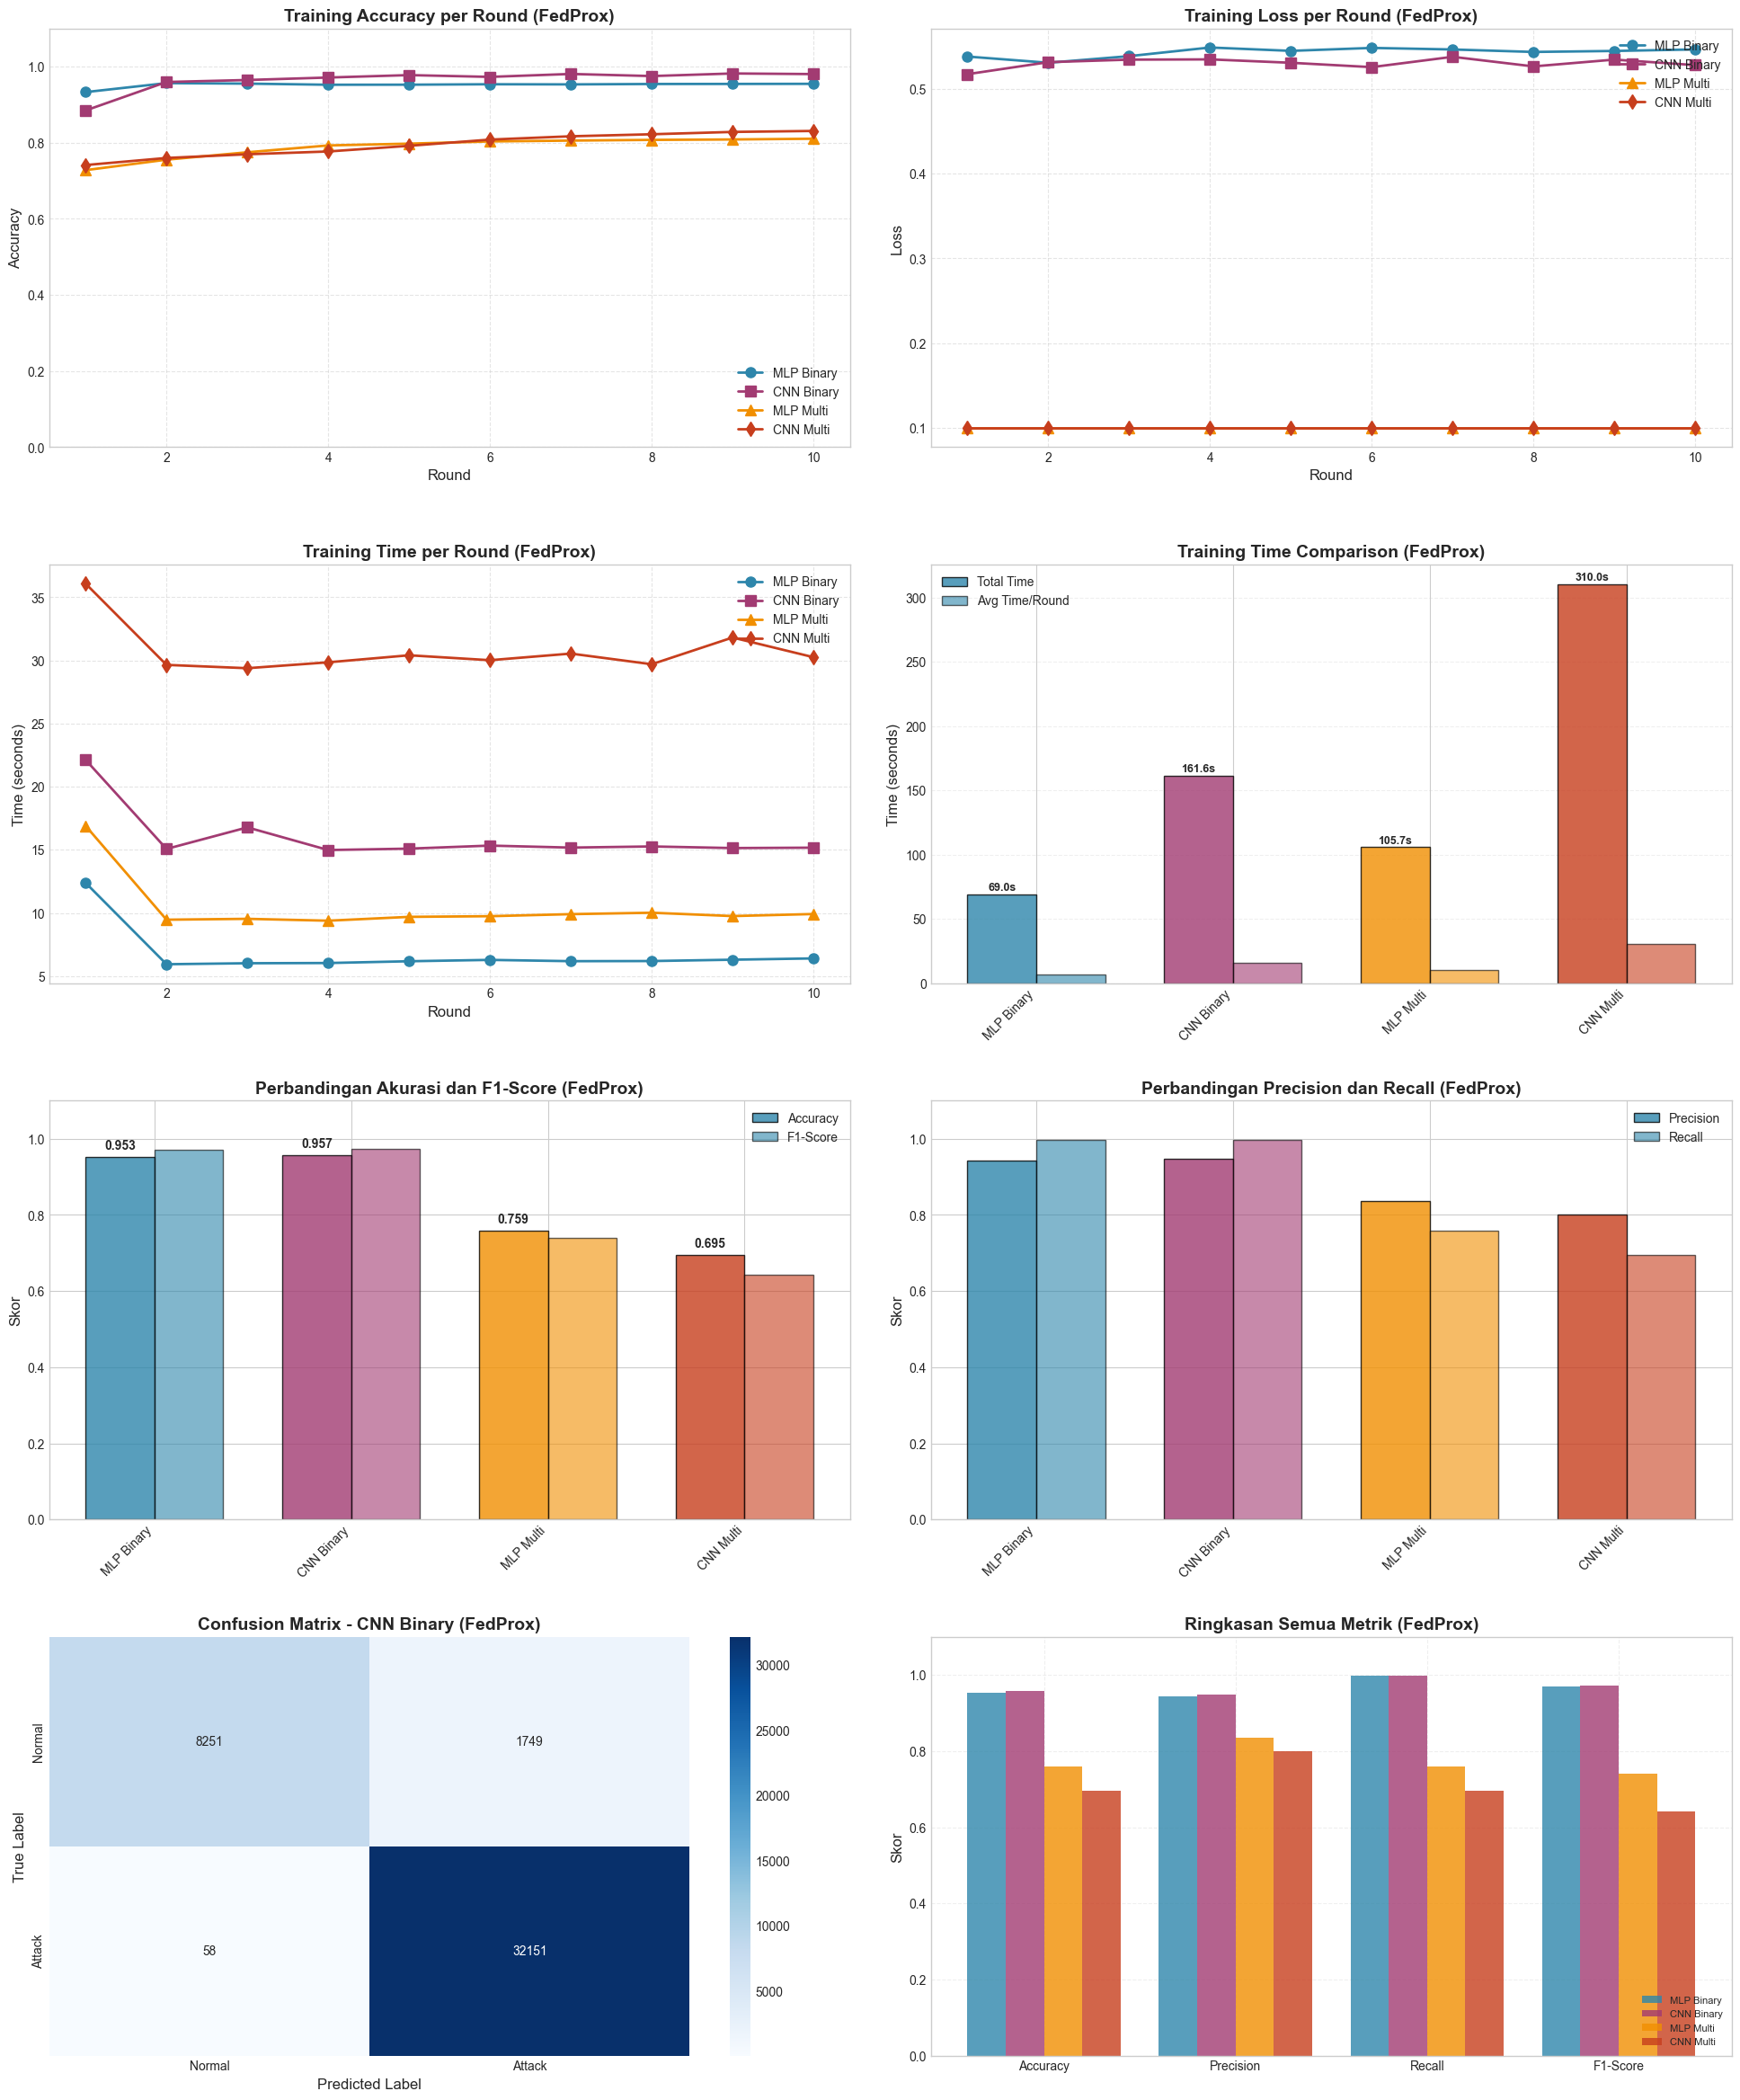

In [10]:
print("\n" + "="*70)
print("📊 VISUALISASI HASIL FLOWER FEDPROX")
print("="*70)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(4, 2, figsize=(20, 24))

model_names = ['MLP Binary', 'CNN Binary', 'MLP Multi', 'CNN Multi']
model_keys = ['mlp_binary', 'cnn_binary', 'mlp_multi', 'cnn_multi']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
markers = ['o', 's', '^', 'd']

# Plot 1: Training Accuracy per Round
axes[0, 0].set_title('Training Accuracy per Round (FedProx)', fontsize=14, fontweight='bold')
for i, (name, key) in enumerate(zip(model_names, model_keys)):
    if all_histories[key]['train_accuracy']:
        rounds = list(range(1, len(all_histories[key]['train_accuracy']) + 1))
        axes[0, 0].plot(rounds, all_histories[key]['train_accuracy'], 
                       label=name, marker=markers[i], color=colors[i], 
                       linewidth=2, markersize=8)

axes[0, 0].set_xlabel('Round', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend(loc='lower right', fontsize=10)
axes[0, 0].grid(True, linestyle='--', alpha=0.5)
axes[0, 0].set_ylim(0, 1.1)

# Plot 2: Training Loss per Round
axes[0, 1].set_title('Training Loss per Round (FedProx)', fontsize=14, fontweight='bold')
for i, (name, key) in enumerate(zip(model_names, model_keys)):
    if all_histories[key]['train_loss']:
        rounds = list(range(1, len(all_histories[key]['train_loss']) + 1))
        axes[0, 1].plot(rounds, all_histories[key]['train_loss'], 
                       label=name, marker=markers[i], color=colors[i], 
                       linewidth=2, markersize=8)

axes[0, 1].set_xlabel('Round', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend(loc='upper right', fontsize=10)
axes[0, 1].grid(True, linestyle='--', alpha=0.5)

# Plot 3: Round Time per Round
axes[1, 0].set_title('Training Time per Round (FedProx)', fontsize=14, fontweight='bold')
for i, (name, key) in enumerate(zip(model_names, model_keys)):
    if all_histories[key]['round_time']:
        rounds = list(range(1, len(all_histories[key]['round_time']) + 1))
        axes[1, 0].plot(rounds, all_histories[key]['round_time'], 
                       label=name, marker=markers[i], color=colors[i], 
                       linewidth=2, markersize=8)

axes[1, 0].set_xlabel('Round', fontsize=12)
axes[1, 0].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 0].legend(loc='upper right', fontsize=10)
axes[1, 0].grid(True, linestyle='--', alpha=0.5)

# Plot 4: Total Training Time Comparison
total_times = [all_histories[key]['total_time'] for key in model_keys]
avg_round_times = [np.mean(all_histories[key]['round_time']) for key in model_keys]

x_pos = np.arange(len(model_names))
width = 0.35

bars_total = axes[1, 1].bar(x_pos - width/2, total_times, width, label='Total Time', 
                            color=colors, alpha=0.8, edgecolor='black')
bars_avg = axes[1, 1].bar(x_pos + width/2, avg_round_times, width, label='Avg Time/Round', 
                          color=colors, alpha=0.6, edgecolor='black')

axes[1, 1].set_title('Training Time Comparison (FedProx)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.3, axis='y')

for bar, t_time in zip(bars_total, total_times):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(total_times)*0.01, 
                    f'{t_time:.1f}s', ha='center', fontsize=9, fontweight='bold')

# Plot 5: Accuracy Comparison
accuracies = [all_metrics[name]['accuracy'] for name in model_names]
f1_scores = [all_metrics[name]['f1_score'] for name in model_names]

bars1 = axes[2, 0].bar(x_pos - width/2, accuracies, width, label='Accuracy', 
                       color=colors, alpha=0.8, edgecolor='black')
bars2 = axes[2, 0].bar(x_pos + width/2, f1_scores, width, label='F1-Score', 
                       color=colors, alpha=0.6, edgecolor='black')

axes[2, 0].set_title('Perbandingan Akurasi dan F1-Score (FedProx)', fontsize=14, fontweight='bold')
axes[2, 0].set_ylabel('Skor', fontsize=12)
axes[2, 0].set_xticks(x_pos)
axes[2, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[2, 0].legend()
axes[2, 0].set_ylim(0, 1.1)

for bar, acc in zip(bars1, accuracies):
    axes[2, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{acc:.3f}', ha='center', fontweight='bold', fontsize=10)

# Plot 6: Precision vs Recall
precisions = [all_metrics[name]['precision'] for name in model_names]
recalls = [all_metrics[name]['recall'] for name in model_names]

bars3 = axes[2, 1].bar(x_pos - width/2, precisions, width, label='Precision', 
                       color=colors, alpha=0.8, edgecolor='black')
bars4 = axes[2, 1].bar(x_pos + width/2, recalls, width, label='Recall', 
                       color=colors, alpha=0.6, edgecolor='black')

axes[2, 1].set_title('Perbandingan Precision dan Recall (FedProx)', fontsize=14, fontweight='bold')
axes[2, 1].set_ylabel('Skor', fontsize=12)
axes[2, 1].set_xticks(x_pos)
axes[2, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[2, 1].legend()
axes[2, 1].set_ylim(0, 1.1)

# Plot 7: Confusion Matrix for Best Binary Model
best_binary = 'MLP Binary' if all_metrics['MLP Binary']['f1_score'] > all_metrics['CNN Binary']['f1_score'] else 'CNN Binary'
y_pred_best = all_metrics[best_binary]['predictions']
cm = confusion_matrix(y_test_bin, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[3, 0],
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
axes[3, 0].set_title(f'Confusion Matrix - {best_binary} (FedProx)', fontsize=14, fontweight='bold')
axes[3, 0].set_ylabel('True Label', fontsize=12)
axes[3, 0].set_xlabel('Predicted Label', fontsize=12)

# Plot 8: Model Comparison Summary
metrics_data = []
for name in model_names:
    metrics_data.append([
        all_metrics[name]['accuracy'],
        all_metrics[name]['precision'],
        all_metrics[name]['recall'],
        all_metrics[name]['f1_score']
    ])

x_metrics = np.arange(4)
bar_width = 0.2

for i, (name, data) in enumerate(zip(model_names, metrics_data)):
    axes[3, 1].bar(x_metrics + i*bar_width, data, bar_width, 
                   label=name, color=colors[i], alpha=0.8)

axes[3, 1].set_title('Ringkasan Semua Metrik (FedProx)', fontsize=14, fontweight='bold')
axes[3, 1].set_ylabel('Skor', fontsize=12)
axes[3, 1].set_xticks(x_metrics + bar_width * 1.5)
axes[3, 1].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
axes[3, 1].legend(loc='lower right', fontsize=8)
axes[3, 1].set_ylim(0, 1.1)
axes[3, 1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout(pad=3.0)
plt.savefig('fedprox_comprehensive_results.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualisasi disimpan sebagai 'fedprox_comprehensive_results.png'")
plt.show()

## BAGIAN 10: LAPORAN AKHIR FEDPROX

In [ ]:
print("\n" + "="*80)
print("📋 LAPORAN AKHIR - FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER")
print("="*80)

print(f"\n📋 INFORMASI EKSPERIMEN:")
print(f"   • Framework: {FRAMEWORK}")
print(f"   • Algoritma: {ALGORITHM}")
print(f"   • Proximal Term (μ) - Binary: {MU_BINARY}, Multi-class: {MU_MULTI}")
print(f"   • Jumlah Klien: {NUM_CLIENTS}")
print(f"   • Distribusi Data: {DATA_DISTRIBUTION}")
print(f"   • Alpha Binary: {ALPHA_BINARY} | Alpha Multi-class: {ALPHA_MULTI}")
print(f"   • Putaran Komunikasi: {NUM_ROUNDS}")
print(f"   • Local Epochs: {LOCAL_EPOCHS}")
print(f"   • Batch Size - Binary: {BATCH_SIZE_BINARY} | Multi-class: {BATCH_SIZE_MULTI}")
print(f"   • SMOTE Target for MITM: {SMOTE_TARGET_MITM:,} samples")
print(f"   • Learning Rate: {LEARNING_RATE}")
print(f"   • Ukuran Dataset: {df.shape[0]:,} sampel")

print(f"\n📊 DISTRIBUSI DATA KE KLIEN:")
for i, (X_client, y_client) in enumerate(client_data_binary):
    print(f"   • Klien {i+1} (Binary): {len(X_client):,} sampel")

print(f"\n⏱️  WAKTU PELATIHAN:")
model_names_keys = [
    ('MLP Binary', 'mlp_binary'),
    ('CNN Binary', 'cnn_binary'),
    ('MLP Multi', 'mlp_multi'),
    ('CNN Multi', 'cnn_multi')
]
total_training_time = sum(all_histories[key]['total_time'] for _, key in model_names_keys)

for name, key in model_names_keys:
    history = all_histories[key]
    print(f"   • {name}:")
    print(f"      - Total: {history['total_time']:.2f}s")
    print(f"      - Per Round (avg): {np.mean(history['round_time']):.2f}s")
    print(f"      - Per Round (min/max): {np.min(history['round_time']):.2f}s / {np.max(history['round_time']):.2f}s")

print(f"\n   • Total Waktu Pelatihan Semua Model: {total_training_time:.2f}s ({total_training_time/60:.2f} menit)")

print(f"\n🏆 MODEL TERBAIK:")
best_binary = max(
    [(name, metrics) for name, metrics in all_metrics.items() if 'Binary' in name],
    key=lambda x: x[1]['f1_score']
)
best_multi = max(
    [(name, metrics) for name, metrics in all_metrics.items() if 'Multi' in name],
    key=lambda x: x[1]['f1_score']
)

print(f"   📍 Klasifikasi Binary:")
print(f"      • Terbaik: {best_binary[0]}")
print(f"      • Accuracy: {best_binary[1]['accuracy']:.4f}")
print(f"      • Precision: {best_binary[1]['precision']:.4f}")
print(f"      • Recall: {best_binary[1]['recall']:.4f}")
print(f"      • F1-Score: {best_binary[1]['f1_score']:.4f}")

print(f"\n   📍 Klasifikasi Multi-class:")
print(f"      • Terbaik: {best_multi[0]}")
print(f"      • Accuracy: {best_multi[1]['accuracy']:.4f}")
print(f"      • Precision: {best_multi[1]['precision']:.4f}")
print(f"      • Recall: {best_multi[1]['recall']:.4f}")
print(f"      • F1-Score: {best_multi[1]['f1_score']:.4f}")

print(f"\n📈 RINGKASAN PERFORMA SEMUA MODEL:")
for name in ['MLP Binary', 'CNN Binary', 'MLP Multi', 'CNN Multi']:
    metrics = all_metrics[name]
    print(f"   • {name}:")
    print(f"      - Accuracy: {metrics['accuracy']:.4f}")
    print(f"      - Precision: {metrics['precision']:.4f}")
    print(f"      - Recall: {metrics['recall']:.4f}")
    print(f"      - F1-Score: {metrics['f1_score']:.4f}")

print(f"\n💡 KESIMPULAN:")
print(f"   • FedProx berhasil melatih {len(all_models)} model pada lingkungan Non-IID")
print(f"   • Proximal term (μ= Binary {MU_BINARY}, Multi {MU_MULTI}) membantu konvergensi pada data heterogen")
print(f"   • FedProx lebih stabil dibandingkan FedAvg pada data yang sangat Non-IID")
print(f"   • Model dapat dengan mudah di-deploy ke production")
print(f"   • Tracking metrik lebih straightforward dengan Flower")

print(f"\n🔧 KEUNGGULAN FEDPROX:")
print(f"   • Convergence lebih stabil pada data Non-IID")
print(f"   • Mengatasi system heterogeneity (klien dengan kemampuan berbeda)")
print(f"   • Proximal term mencegah model lokal terlalu jauh dari global")
print(f"   • Hyperparameter μ dapat disesuaikan untuk berbagai skenario")
print(f"   • Implementasi sederhana dengan Flower framework")

print(f"\n📊 PARAMETER FEDPROX:")
print(f"   • μ (mu) Binary = {MU_BINARY}: Proximal term untuk binary models")
print(f"   • μ (mu) Multi = {MU_MULTI}: Proximal term untuk multi-class (reduced 10x)")
print(f"   • Proximal term: (μ/2)||w - w_global||²")
print(f"   • Lower μ for multi-class allows more local learning on imbalanced data")
print(f"   • Aggregation: Weighted averaging (sama dengan FedAvg)")
print(f"   • Training: Local loss + proximal term")


print("\n✅ EKSPERIMEN FEDPROX SELESAI")
print("="*80)


📋 LAPORAN AKHIR - FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER

📋 INFORMASI EKSPERIMEN:
   • Framework: Flower (flwr)
   • Algoritma: Federated Proximal (FedProx)
   • Proximal Term (μ) - Binary: 0.01, Multi-class: 0.001
   • Jumlah Klien: 3
   • Distribusi Data: Non-IID (Dirichlet)
   • Alpha Binary: 0.4 | Alpha Multi-class: 0.6
   • Putaran Komunikasi: 10
   • Local Epochs: 3
   • Batch Size - Binary: 512 | Multi-class: 256
   • SMOTE Target for MITM: 3,000 samples
   • Learning Rate: 0.001
   • Ukuran Dataset: 211,043 sampel

📊 DISTRIBUSI DATA KE KLIEN:
   • Klien 1 (Binary): 40,199 sampel
   • Klien 2 (Binary): 127,540 sampel
   • Klien 3 (Binary): 1,095 sampel

⏱️  WAKTU PELATIHAN:
   • MLP Binary:
      - Total: 68.99s
      - Per Round (avg): 6.79s
      - Per Round (min/max): 5.94s / 12.38s
   • CNN Binary:
      - Total: 161.62s
      - Per Round (avg): 16.01s
      - Per Round (min/max): 14.98s / 22.12s
   • MLP Multi:
      - Total: 105.72s
      - Per Round (avg): 10.43s
   

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. Lease ID: 050000000267101bc5fc21bf3aebddb6d7f6b2223f1180bf77e5e557ad575320 Worker ID: 751011c1abea71d0e143f79c905340f9993f68a5c5094ab01691fca4 Node ID: 2e3fca1aaf73980b827488b1af84eac3308bcabe21babba9dd10673e Worker IP address: 192.168.0.129 Worker port: 40489 Worker PID: 508042 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.


: 